In [1]:
import copy
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from scipy.stats import entropy
# Done
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import itertools

# Assignment 3

## Generative Adversarial Networks on MNIST

In this assignment you will create and train a GAN to generate images of digits that mimic those in the MNIST dataset.

### Evaluation metric: Inception Score

Rather than just eye-balling whether GAN samples look good or not, researchers have come up with mulitple objective metrics for determining the quality and the diversity of GAN outputs. We will use one of the metrics called the *Inception Score*.

Calculating the Inception Score involves running a pretrained neural network. This is where the name is from: the authors who proposed this metric used a pretrained [Inception Network](https://arxiv.org/pdf/1409.4842.pdf) from Tensorflow in their [paper](https://proceedings.neurips.cc/paper/2016/file/8a3363abe792db2d8761d6403605aeb7-Paper.pdf). Since we will be using the MNIST dataset in this assignment, we provide a simpler neural work pretrained on MNIST as the scoring model.

The idea behind the Inception Score is simple: a good GAN should generate *meaningful* and *diverse* samples. For MNIST, a specific sample is "meaningful" if it looks like any of the 10 digits. When we take a good digit classifier and run it on this sample, it should assign high probability to one of the 10 classes and low probability to the others. In information theory terms, this means the predicted label distribution $p(y|x)$ for any specific sample $x$ should have high entropy. On the other hand, if the generated samples are diverse, they should be able to cover all 10 classes when we generate a large enough set of samples. This means that the "average" label distribution $p(y) = \int p(y|x=G(z)) \mathrm{d}z$ should have low entropy. The Inception Score is define by $\exp (\mathbb{E}_x \mathrm{KL}(p(y|x) || p(y)))$, where $\mathrm{KL}(P||Q)$ is the K-L divergence, which is often used to measure how probability distribution $P$ is different from distribution $Q$. Intuitively, if the generated samples are good, $p(y|x)$ should be different from $p(y)$, since one should have high entropy while the other should have low entropy.

Don't be too worried if you don't fully get how the score is defined and calculated. Just remember that in this assignment, we want our GAN to have a high Inception Score.

In [2]:
# Pretrained model used to evaluation the inception score.
class ScoringModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(7 * 7 * 64, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

    
def inception_score_mnist(
    imgs,
    model_path='weights/mnist.ckpt',
    batch_size=32,
    num_splits=10,
):
    """Computes the inception score of `imgs`.
    
    Args:
    - imgs: Array of size (number of data points, 1, 28, 28)
    - batch_size: Batch size for feeding data into the pretrained MNIST model.
    - num_splits: Number of splits. We split the samples into multiple subsets
        and calculate the scores on each of them. Their mean is used as the
        final score.
    """
    # Verify that input arguments have the correct formats.
    assert type(imgs) == np.ndarray
    assert imgs.shape[1:] == (1, 28, 28)
    assert batch_size > 0
    assert len(imgs) > batch_size
    
    # Choose device to be used.
    #device = 'cuda:0' if torch.cuda.is_available() else 'mps'
    device = torch.device('cuda' if torch.cuda.is_available() else 'mps')
    # Preprocess input.
    imgs = copy.copy(imgs)
    imgs = (imgs - 0.1307) / 0.3081
    
    # Set up dataloader.
    dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)

    # Load pretrained scoring model.
    model = ScoringModel()
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)
    model.eval()

    # Get predictions.
    preds = []
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        with torch.no_grad():
            logits = model(batch)
            probs = F.softmax(logits, dim=1).cpu().numpy()
        preds.append(probs)
    preds = np.concatenate(preds)

    # Compute the mean KL divergence.
    split_scores = []

    for i in range(num_splits):
        n = len(imgs) // num_splits
        split = preds[i*n:(i+1)*n, :]
        py = np.mean(split, axis=0)
        scores = []
        for i in range(split.shape[0]):
            pyx = split[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))
    
    return np.mean(split_scores), np.std(split_scores)

Now, let's try to calculate the Inception score on the actual MNIST dataset.

Make sure that the provided file `mnist.ckpt` is under `./weights`. Alternatively, you can specify its path via the `model_path` argument of `inception_score_mnist()`. If using Google Colab, click `View > Table of Contents > Files` and then upload it.

In [3]:
transform = torchvision.transforms.ToTensor()
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform),
    batch_size=500, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform),
    batch_size=500, shuffle=False)

x, _ = next(iter(train_loader))
x = x.cpu().data.numpy()
print(x.shape)
x = x.reshape((-1,1,28,28))
print('Shape of data:',x.shape)
mean, std = inception_score_mnist(x)
print(f'Inception Score: mean={mean:.3f}, std={std:.3f}')

(500, 1, 28, 28)
Shape of data: (500, 1, 28, 28)
Inception Score: mean=9.059, std=0.343


The score for the real MNIST dataset should be above 8.


### Generating MNIST images (100 points)

As you did with the Gaussian distribution example in the weekly notebook, define and train a GAN to generate images that mimic those in the MNIST dataset.

#### Deliverables

- After training your model, generate at least 1500 samples using the trained generator, and evaluate your model by calculating the Inception score on the generated samples.
- Pick a few generated samples and visualize them.
- Plot the training losses for the discriminator and the generator.

Given the limited computational resources, you will want to achieve an Inception score of 1.5 or greater for full credits. A score of 1.5 won't yield great images. For nice looking images, you'll need an Inception score of around 6.0, but it is not needed for full credits.

#### Model Submission

For more complicated architectures, if your model takes a long time to train, you will need to save the model and write a code snippet that loads it such that the code runs with no errors and we can grade it easily. In this case, set `epochs = 0` and include the saved model in your submission (or a Google drive share link if its too large).

#### Tips

- It will be easier to get better results with a convolutional GAN. You may find this [tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html) on [DCGAN](https://arxiv.org/pdf/1511.06434.pdf) helpful. The generators of DCGANs make use of transposed convolutions (`nn.ConvTranspose2d` in PyTorch) to map features to larger sizes. This [article](https://d2l.ai/chapter_computer-vision/transposed-conv.html) does a good job illustrating how they work.
- Feel free to try different architectures, layers, optimizers, training schemes and other hyperparameters. Particularly, if training with one type of optimizer is slow or unstable, give other types of optimizers a try.

There are plenty of online resources about GAN that you can reference for inspiration. But do not plagiarize. Please write your own custom networks.

# ------------------Testing Pipeline---------------------

## Test on 3000 images generated by pre-trained generator (since my laptop is M1 Mac, I use "mps" for training)

Inception Score: mean=7.908, std=0.187


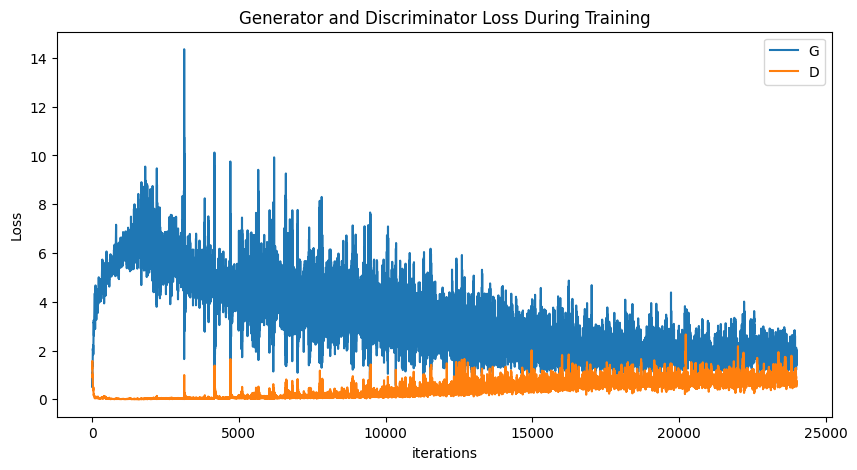

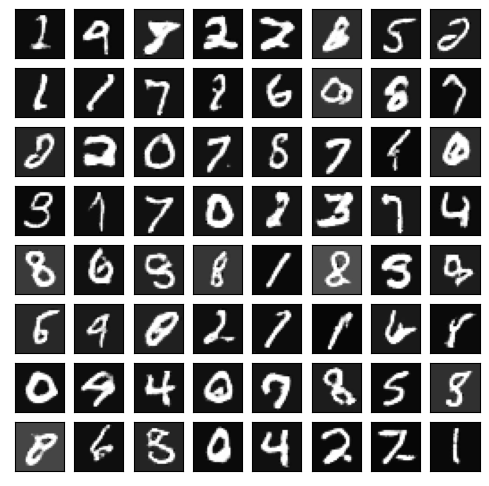

In [4]:
# define generator and discriminator
class GANGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf):
        super(GANGenerator, self).__init__()
        self.network = nn.Sequential(
            # state size. nz
            nn.ConvTranspose2d(input_nc, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 0, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 10 x 10
            nn.ConvTranspose2d(ngf * 2, ngf, 5, 1, 0, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 14 x 14
            nn.ConvTranspose2d(ngf, output_nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 28 x 28
        )
  
    def forward(self, input):
        output = self.network(input)
        return output

device = torch.device('cuda' if torch.cuda.is_available() else 'mps')
model_G = GANGenerator(100, 1, 32).to(device)
model_G.load_state_dict(torch.load('./weights/Generator_MPS.ckpt'))
test_noise = torch.randn(3000, 100, 1, 1, device=device)
with torch.no_grad():
    test_fake_img = model_G(test_noise).detach().cpu().numpy()

test_mean, test_std = inception_score_mnist(test_fake_img)
print(f'Inception Score: mean={test_mean:.3f}, std={test_std:.3f}')

# plot training loss
total_loss = np.load('./weights/loss.npz')
discriminator_loss = total_loss['dloss']
generator_loss = total_loss['gloss']
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(generator_loss,label="G")
plt.plot(discriminator_loss,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


# select 64 images for visualization
fig, ax = plt.subplots(8, 8, figsize=(6,6))
for i, j in itertools.product(range(8), range(8)):
        ax[i,j].get_xaxis().set_visible(False)
        ax[i,j].get_yaxis().set_visible(False)
for k in range(64):
    i = k//8
    j = k%8
    ax[i,j].cla()
    ax[i,j].imshow(test_fake_img[k].reshape(28,28), cmap='gray')

# ------------------Training Pipeline---------------------

## Prepare necessary libraries

In [5]:
# Done
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')
print("Using", device)

Random Seed:  999
Using mps


## Prepare training hyperparameters

In [6]:
# define hyperparameters for the GAN model
# Root directory for dataset
dataroot = "./data"

# Batch size during training
batch_size = 500

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 28

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 32

# Size of feature maps in discriminator
ndf = 32

# Number of training epochs
num_epochs = 0
#num_epochs = 200
# Learning rate for optimizers
lr = 0.0002

## Prepare GAN generator and discriminator network

In [7]:
# define generator and discriminator
class GANGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf):
        super(GANGenerator, self).__init__()
        self.network = nn.Sequential(
            # state size. nz
            nn.ConvTranspose2d(input_nc, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 0, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 10 x 10
            nn.ConvTranspose2d(ngf * 2, ngf, 5, 1, 0, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 14 x 14
            nn.ConvTranspose2d(ngf, output_nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 28 x 28
        )
  
    def forward(self, input):
        output = self.network(input)
        return output

class GANDiscriminator(nn.Module):
    def __init__(self, input_nc, output_nc, ndf):
        super(GANDiscriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(input_nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 4, output_nc, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)


## Define training loss function and optimizer

In [8]:
# prepare network, loss function and optimizers
D = GANDiscriminator(nc, nc, ndf).to(device)
G = GANGenerator(nz, nc, ngf).to(device)
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(32, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(D.parameters(), lr=lr)
optimizerG = optim.Adam(G.parameters(), lr=lr)

## Training

In [9]:
# Training
G_losses = []
D_losses = []
img_list = []
iters = 0
print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, (img, _) in enumerate(train_loader):
        ##############################
        #   Training discriminator   #
        ##############################
        D.zero_grad()
        torch_img = img.to(device)
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        D_output = D(torch_img)
        D_loss_real = criterion(D_output, label)
        D_loss_real.backward()
        D_x = D_output.mean().item()
        
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake_img = G(noise)
        label.fill_(fake_label)
        D_fake_output = D(fake_img.detach())
        D_loss_fake = criterion(D_fake_output, label)
        D_loss_fake.backward()
        D_G_z1 = D_fake_output.mean().item()
        loss_D = D_loss_real + D_loss_fake
        optimizerD.step()
        ##############################
        #   Training generator       #
        ##############################
        G.zero_grad()
        label.fill_(real_label)
        D_output = D(fake_img)
        loss_G = criterion(D_output, label)
        loss_G.backward()
        D_G_z2 = D_output.mean().item()
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_loader),
                     loss_D.item(), loss_G.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                fake = G(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

torch.save(D.state_dict(), './weights/Discriminator_MPS.ckpt')
torch.save(G.state_dict(), './weights/Generator_MPS.ckpt')
np.savez('./weights/loss.npz', gloss = G_losses, dloss = D_losses)


Starting Training Loop...
[0/200][0/120]	Loss_D: 1.2994	Loss_G: 1.0821	D(x): 0.5144	D(G(z)): 0.4574 / 0.3459
[0/200][50/120]	Loss_D: 0.1845	Loss_G: 3.1385	D(x): 0.9168	D(G(z)): 0.0863 / 0.0444
[0/200][100/120]	Loss_D: 0.0915	Loss_G: 3.0598	D(x): 0.9759	D(G(z)): 0.0639 / 0.0474
[1/200][0/120]	Loss_D: 0.0416	Loss_G: 4.3219	D(x): 0.9781	D(G(z)): 0.0184 / 0.0147
[1/200][50/120]	Loss_D: 0.0445	Loss_G: 4.3532	D(x): 0.9766	D(G(z)): 0.0194 / 0.0134
[1/200][100/120]	Loss_D: 0.0435	Loss_G: 4.7474	D(x): 0.9719	D(G(z)): 0.0132 / 0.0088
[2/200][0/120]	Loss_D: 0.0294	Loss_G: 4.4691	D(x): 0.9881	D(G(z)): 0.0167 / 0.0116
[2/200][50/120]	Loss_D: 0.0469	Loss_G: 4.4720	D(x): 0.9789	D(G(z)): 0.0240 / 0.0148
[2/200][100/120]	Loss_D: 0.0528	Loss_G: 5.3429	D(x): 0.9722	D(G(z)): 0.0213 / 0.0133
[3/200][0/120]	Loss_D: 0.0883	Loss_G: 4.3237	D(x): 0.9665	D(G(z)): 0.0485 / 0.0180
[3/200][50/120]	Loss_D: 0.1203	Loss_G: 4.1718	D(x): 0.9463	D(G(z)): 0.0532 / 0.0220
[3/200][100/120]	Loss_D: 0.0890	Loss_G: 4.6834	D(x)

## Plot the loss plots for discriminator and generator

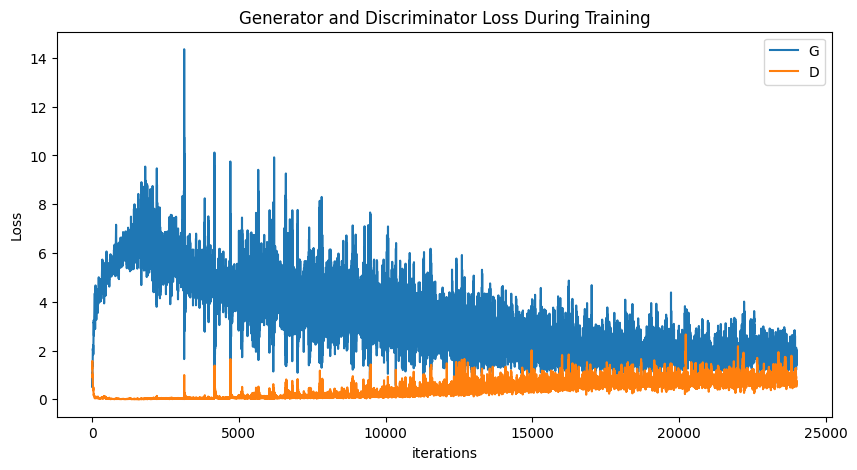

In [10]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Show 32 plots for the training evolution process

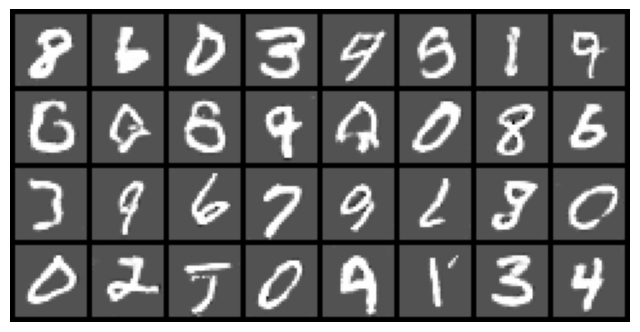

In [11]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())